In [1]:
# CELL 1: Importing libraries and set random seed

# random: Python's built-in module for randomness (shuffling, random choices)
import random

# time: used to measure how long algorithms take to run
import time

# Path from pathlib: helps us work with file paths in a clean, OS-independent way
from pathlib import Path

# numpy: fundamental package for numerical computing in Python
import numpy as np

# pandas: used for data handling and reading CSV files
import pandas as pd

# matplotlib: used for plotting routes and performance graphs
import matplotlib.pyplot as plt


# Fix random seed for reproducibility

# We store the seed in a constant so we can reuse it in multiple places
RANDOM_SEED = 42
# Different runs give different results so by fixing seed same random choices occur every run.

# Set seed for Python's random module
random.seed(RANDOM_SEED)

# Set seed for NumPy's random generator (separate from random)
np.random.seed(RANDOM_SEED)

# Plot settings (optional, just for nicer visuals)

# Default figure size for plots (width, height)
plt.rcParams["figure.figsize"] = (7, 5)



In [2]:
# CELL 2: Loading the TSP dataset (cities.csv)


def load_cities(csv_file):
    """
    Load the TSP dataset from a CSV file.
    Expected columns in the CSV:
    - "City" : label or name of the city
    - "X"    : x-coordinate
    - "Y"    : y-coordinate
    """

    # Convert the string path into a Path object for safer path handling
    file_path = Path(csv_file)

    # Check if the file actually exists. If not, stop with a clear error.
    if not file_path.exists():
        raise FileNotFoundError(
            f"File '{csv_file}' not found. "
        )

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Checking that the required columns are present in the file
    required_columns = {"City", "X", "Y"}
    if not required_columns.issubset(df.columns):
        raise ValueError(
            f"CSV file must contain columns {required_columns}, "
            f"but found {set(df.columns)}"
        )

    # Return the loaded DataFrame
    return df


# --------- Load dataset using the function above ---------

cities_df = load_cities("cities.csv")

# Showing the first five rows to confirm it loaded correctly
print(cities_df.head())

# Showing how many cities there are
print("Number of cities:", len(cities_df))

# Showing the column names
print("Columns:", list(cities_df.columns))



     City          X          Y
0  City_1  37.454012  95.071431
1  City_2  73.199394  59.865848
2  City_3  15.601864  15.599452
3  City_4   5.808361  86.617615
4  City_5  60.111501  70.807258
Number of cities: 50
Columns: ['City', 'X', 'Y']


In [3]:
#This will convert the city coordinates into a numerical distance matrix, which stores the distance between every pair of cities.
def compute_distance_matrix(coords):
    """
    Convert city coordinates into a pairwise Euclidean distance matrix.
    """ 
    n = coords.shape[0] #n=50, coords contain one entry per city
    distance_matrix = np.zeros((n, n))

    for i in range(n): #Start with city i 
        for j in range(i + 1, n): # Compare the city i with the latter cities after it.
            
            #Computing the distance between city i and city j using Euclidean distance:
            distance = np.linalg.norm(coords[i] - coords[j])
            
            # Distance matrix is symmetric
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
            # Even if cities are different, the distance between them is direction independent.
            
    return distance_matrix

#Cacluating the total distance travelled by the salesman in given tour.
def tour_length(tour, distance_matrix):
    total_distance = 0 #Starting with 0 distance
    for i in range(len(tour) - 1):
        total_distance += distance_matrix[tour[i]][tour[i + 1]] #Measures all distances along the tour.
    total_distance += distance_matrix[tour[-1]][tour[0]] #Ensures salesman return to the starting point.
    return total_distance



#This will find the best optimising tour for the salesman
def generate_random_tour(n_cities):
    tour = list(range(n_cities)) # Each city appears exactly once.
    random.shuffle(tour)
    return tour


coordinates = cities_df[["X", "Y"]].to_numpy()
distance_matrix = compute_distance_matrix(coordinates)
print("Distance matrix shape:", distance_matrix.shape)


Distance matrix shape: (50, 50)


In [4]:
# CELL 4: Neighbourhood generation using swap moves

def generate_all_neighbours(tour):
    """
    Generate ALL neighbours of a tour using a simple swap operator.

    A neighbour is created by swapping the positions of two cities
    in the tour. By swapping we get small changes in the tour.

    Example:
        tour        = [0, 1, 2, 3]
        swap i=1,j=3 -> [0, 3, 2, 1]
    """
    #Initialising the list
    neighbours = []      # list to store all neighbour tours
    n = len(tour)        # number of cities in the tour

    # Loop over all pairs (i, j) with i < j
    for i in range(n - 1):
        for j in range(i + 1, n): #This will avoid duplicate swaps and computation.

            # Copy the current tour so we don't overwrite the original.
            new_tour = tour.copy() #Any changes to the original tour do not affect new_tour.

            # Swap the cities at positions i and j
            new_tour[i], new_tour[j] = new_tour[j], new_tour[i]

            # Add the new tour to the neighbour list
            neighbours.append(new_tour)

    return neighbours


In [5]:
# CELL 5: Steepest Ascent Hill Climbing (single run)

def steepest_ascent_hill_climbing(distance_matrix, max_iterations=2000):
    """
    Steepest Ascent Hill Climbing algorithm for the TSP.

    Parameters
    ----------
    distance_matrix : 2D numpy array
        Precomputed distances between each pair of cities.
    max_iterations : int
        Maximum number of iterations.

    Returns
    -------
    best_tour : list of int
        Best tour found during the search.
    best_length : float
        Total distance of best_tour.
    iterations_used : int
        Number of iterations actually performed.
    runtime_seconds : float
        Total time taken by the algorithm in seconds.
    """

    # Number of cities obtained from the distance matrix dimension
    n_cities = distance_matrix.shape[0]

    #Step 1: create an initial random solution C
    current_tour = generate_random_tour(n_cities)
    current_length = tour_length(current_tour, distance_matrix)

    # At the beginning, the current solution is also the best known
    best_tour = current_tour.copy()
    best_length = current_length # This is calculated using the Euclidean distance.

    # Save the start time for runtime measurement
    start_time = time.perf_counter()

    #Step 2: repeat until no improvement or max_iterations
    for iteration in range(max_iterations):

        # Generate all neighbours of the current solution
        neighbours = generate_all_neighbours(current_tour) #Using the swap based neighbourhood from Cell 4.

        # Assume no better neighbour is found yet in this iteration
        better_neighbour_found = False

        # Start with current solution as the best in this iteration
        best_neighbour_tour = current_tour
        best_neighbour_length = current_length

        # Examine every neighbour
        for neighbour in neighbours:
            neighbour_length = tour_length(neighbour, distance_matrix)

            # If this neighbour is better, remember it
            if neighbour_length < best_neighbour_length: #Lower distance = better solution
                better_neighbour_found = True
                best_neighbour_tour = neighbour
                best_neighbour_length = neighbour_length

        # After checking all neighbours:

        if better_neighbour_found:
            # Move "uphill" to the best neighbour (steepest improvement)
            current_tour = best_neighbour_tour
            current_length = best_neighbour_length

            # Update global best if this is the best so far
            #This will protect against losing the best solution found so far.
            if current_length < best_length: 
                best_tour = current_tour.copy()
                best_length = current_length
        else:
            # No better neighbour found: we reached a local optimum
            iterations_used = iteration + 1
            break

    else:
        # The 'else' executes if the loop ended without a 'break'
        # -> we reached max_iterations
        iterations_used = max_iterations

    # Compute total runtime in seconds
    runtime_seconds = time.perf_counter() - start_time

    # Return final results
    return best_tour, best_length, iterations_used, runtime_seconds


# --------- Test the hill climber on the full 50-city instance ---------

best_tour_hc, best_length_hc, iters_hc, time_hc = (
    steepest_ascent_hill_climbing(
        distance_matrix,
        max_iterations=500
    )
)

print("Steepest Ascent Hill Climbing (single run)")
print("Best tour length:", best_length_hc)
print("Iterations used:", iters_hc)
print("Runtime (seconds):", time_hc)



Steepest Ascent Hill Climbing (single run)
Best tour length: 757.7519060416915
Iterations used: 48
Runtime (seconds): 0.431988041033037


In [6]:
# CELL 6: Helper function to run Hill Climbing multiple times

def run_hill_climbing_experiments(distance_matrix, n_runs=10):
    """
    Run Steepest Ascent Hill Climbing multiple times
    and collect statistics.

    Parameters
    ----------
    distance_matrix : 2D numpy array
    n_runs : int is set as 10 because Hill Climbing is stochastic so a single run won't be enough to judge the performance.
        Number of independent runs

    Returns
    -------
    results : list of dict
        Each entry contains best_length and runtime
    """

    results = [] # Empty list that'll store one result per run.

    for run in range(n_runs):

        # Change seed slightly each run so initial solution differs
        random.seed(RANDOM_SEED + run)
        np.random.seed(RANDOM_SEED + run)
        

        best_tour, best_length, iterations, runtime = (
            steepest_ascent_hill_climbing(distance_matrix)
        )


        results.append({
            "best_length": best_length,
            "runtime": runtime,
            "iterations": iterations
        })

    return results



In [7]:
# CELL 7: Genetic Algorithm helper functions

def fitness(tour, distance_matrix):
    """
    Fitness function for GA.
    Smaller distance = higher fitness.
    """
    return 1.0 / (tour_length(tour, distance_matrix) + 1e-10)


def generate_initial_population(pop_size, n_cities):
    """
    Create initial population of random tours.
    """
    population = []
    for _ in range(pop_size):
        population.append(generate_random_tour(n_cities))
    return population


def tournament_selection(population, distance_matrix, k=3):
    """
    Tournament selection:
    pick k individuals randomly and return the best one.
    """
    selected = random.sample(population, k)
    selected.sort(key=lambda t: tour_length(t, distance_matrix))
    return selected[0]


def order_crossover(parent1, parent2):
    """
    Order Crossover (OX) for TSP.
    """
    size = len(parent1)
    i, j = sorted(random.sample(range(size), 2))

    child = [None] * size

    # Copy segment from parent1
    child[i:j] = parent1[i:j]

    # Fill remaining positions from parent2
    pos = j
    for city in parent2:
        if city not in child:
            if pos >= size:
                pos = 0
            child[pos] = city
            pos += 1

    return child


def swap_mutation(tour, mutation_rate):
    """
    Swap mutation: swap two cities with given probability.
    """
    for i in range(len(tour)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(tour) - 1)
            tour[i], tour[j] = tour[j], tour[i]


In [8]:
# CELL 8: Genetic Algorithm main function


def genetic_algorithm(distance_matrix,
                      pop_size=60,
                      generations=300,
                      crossover_rate=0.9,
                      mutation_rate=0.02):
    """
    Genetic Algorithm for the TSP.
    """

    n_cities = distance_matrix.shape[0]

    # Step 1: initialise population
    population = generate_initial_population(pop_size, n_cities)

    start_time = time.perf_counter()

    # Step 2: evolve population
    for generation in range(generations):

        new_population = []

        # Elitism: keep best individual
        population.sort(key=lambda t: tour_length(t, distance_matrix))
        new_population.append(population[0])

        # Generate rest of population
        while len(new_population) < pop_size:

            parent1 = tournament_selection(population, distance_matrix)
            parent2 = tournament_selection(population, distance_matrix)

            # Crossover
            if random.random() < crossover_rate:
                child = order_crossover(parent1, parent2)
            else:
                child = parent1[:]

            # Mutation
            swap_mutation(child, mutation_rate)

            new_population.append(child)

        population = new_population

    # Final best solution
    best_tour = min(population, key=lambda t: tour_length(t, distance_matrix))
    best_length = tour_length(best_tour, distance_matrix)

    runtime = time.perf_counter() - start_time

    return best_tour, best_length, runtime


In [9]:
### CELL 9: Run experiments for 10–50 cities


results = []

city_sizes = [10, 20, 30, 40, 50]

for n in city_sizes:

    sub_coords = coordinates[:n]
    sub_distance_matrix = compute_distance_matrix(sub_coords)

    # Hill Climbing
    hc_results = run_hill_climbing_experiments(sub_distance_matrix, n_runs=10)

    for r in hc_results:
        results.append({
            "algorithm": "Hill Climbing",
            "cities": n,
            "best_length": r["best_length"],
            "runtime": r["runtime"]
        })

    # Genetic Algorithm
    for run in range(10):
        best_tour, best_length, runtime = genetic_algorithm(sub_distance_matrix)
        results.append({
            "algorithm": "Genetic Algorithm",
            "cities": n,
            "best_length": best_length,
            "runtime": runtime
        })

results_df = pd.DataFrame(results)
print(results_df.head())


       algorithm  cities  best_length   runtime
0  Hill Climbing      10   290.306774  0.001223
1  Hill Climbing      10   290.306774  0.001600
2  Hill Climbing      10   290.306774  0.001283
3  Hill Climbing      10   290.306774  0.001215
4  Hill Climbing      10   290.306774  0.001121


In [10]:
# CELL 10: Save results for report and analysis

results_df.to_csv("tsp_results.csv", index=False)
print("Results saved to tsp_results.csv")


Results saved to tsp_results.csv


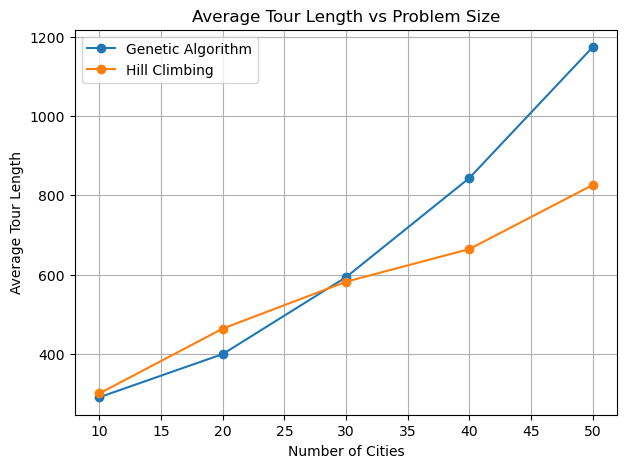

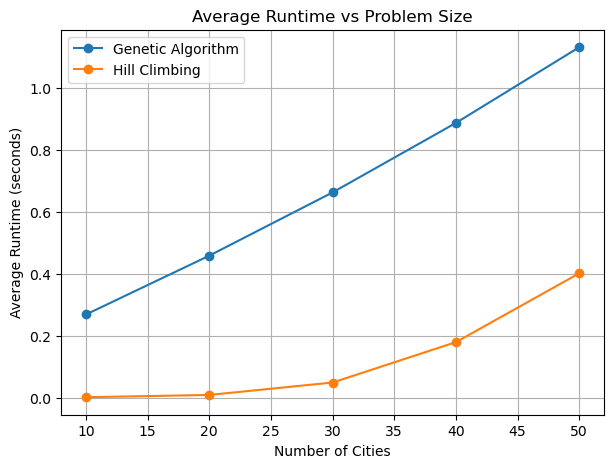

In [11]:
# CELL 11: Plot performance comparison


import matplotlib.pyplot as plt

# Average distance by algorithm and city size
avg_results = results_df.groupby(
    ["algorithm", "cities"]
)["best_length"].mean().reset_index()

plt.figure()
for algo in avg_results["algorithm"].unique():
    subset = avg_results[avg_results["algorithm"] == algo]
    plt.plot(
        subset["cities"],
        subset["best_length"],
        marker="o",
        label=algo
    )

plt.xlabel("Number of Cities")
plt.ylabel("Average Tour Length")
plt.title("Average Tour Length vs Problem Size")
plt.legend()
plt.grid(True)
plt.show()


# Average runtime
avg_runtime = results_df.groupby(
    ["algorithm", "cities"]
)["runtime"].mean().reset_index()

plt.figure()
for algo in avg_runtime["algorithm"].unique():
    subset = avg_runtime[avg_runtime["algorithm"] == algo]
    plt.plot(
        subset["cities"],
        subset["runtime"],
        marker="o",
        label=algo
    )

plt.xlabel("Number of Cities")
plt.ylabel("Average Runtime (seconds)")
plt.title("Average Runtime vs Problem Size")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# CELL 12: Save best 50-city route

# Run GA on full 50-city problem to get best route
best_tour, best_length, runtime = genetic_algorithm(distance_matrix)

print("Best 50-city tour distance (GA):", best_length)

# Convert indices to city names
best_route_cities = [cities_df.iloc[i]["City"] for i in best_tour]

route_df = pd.DataFrame({
    "Order": range(1, len(best_route_cities) + 1),
    "City": best_route_cities
})

route_df.to_csv("best_50_city_route.csv", index=False)
print("Best route saved to best_50_city_route.csv")


Best 50-city tour distance (GA): 1235.6754070824184
Best route saved to best_50_city_route.csv


In [15]:
# CELL 13: Visualise TSP route on a 2D graph


def plot_tsp_route(cities_df, tour, title="TSP Route"):
    """
    Plot a TSP route on a 2D plane.

    Parameters
    ----------
    cities_df : pandas DataFrame
        DataFrame containing City, X, Y columns
    tour : list of int
        Order in which cities are visited (indices)
    title : str
        Title of the plot
    """

    # Extract X and Y coordinates
    x_coords = cities_df["X"].to_numpy()
    y_coords = cities_df["Y"].to_numpy()

    # Create ordered coordinates based on tour
    tour_x = [x_coords[i] for i in tour] + [x_coords[tour[0]]]
    tour_y = [y_coords[i] for i in tour] + [y_coords[tour[0]]]

    # Plot the route
    plt.figure()
    plt.plot(tour_x, tour_y, marker="o", linestyle="-")

    # Annotate each city with its label (city name)
    for i in tour:
        plt.text(
            cities_df.iloc[i]["X"],
            cities_df.iloc[i]["Y"],
            str(cities_df.iloc[i]["City"]),
            fontsize=8
        )

    # Label axes and title
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(title)

    plt.grid(True)
    plt.show()


Best 50-city tour distance (GA): 1124.8876872815745
Runtime (seconds): 1.164663042058237


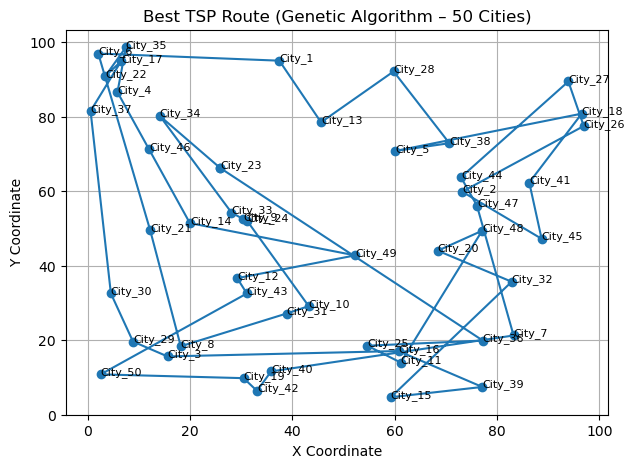

In [17]:
# CELL 14: Plot best 50-city route (Genetic Algorithm)

# Run GA on the full 50-city problem
best_tour, best_length, runtime = genetic_algorithm(distance_matrix)

print("Best 50-city tour distance (GA):", best_length)
print("Runtime (seconds):", runtime)

# Plot the resulting best route
plot_tsp_route(
    cities_df=cities_df,
    tour=best_tour,
    title="Best TSP Route (Genetic Algorithm – 50 Cities)"
)

